# Task 1 - DeepLearning

Install all libraries

In [ ]:
!pip install -r requirements.txt

# **EDA**


In [ ]:
#I am working in Google Colab and use Google Drive to store data

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

In [ ]:
#path to folders
#need to paste actual path

train_dir = '/content/drive/MyDrive/trainee_dataset/train'
test_dir = '/content/drive/MyDrive/trainee_dataset/test'

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

I made here all base transformations and augmentation for class 0, because as we can see later class 1 in 9 times bigger than class 0. I also tried a class weights method, but it has not so big effect.

In [ ]:
class ArtifactDataset(Dataset):
    """
    Class for reading Dataset

    Features:
    - Reads .png images and parses labels from filenames
    - Supports different transformation strategies:
        * Class 0: full data augmentation
        * Class 1: basic resizing and normalization.
    - Prints the class distribution upon initialization for quick data sanity check.
    - Handles missing or unreadable image files by replacing them with a black placeholder image.

    Args:
        image_dir (str): Path to the directory containing image files.
        transform (callable, optional): Transformations to apply to class 0 samples.

    Returns:
        Tuple[Tensor, int]: Transformed image tensor and its corresponding label.
    """

    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for filename in os.listdir(image_dir):
            if filename.endswith(".png"):
                label = int(filename.split("_")[-1].split(".")[0])
                img_path = os.path.join(image_dir, filename)
                self.images.append(img_path)
                self.labels.append(label)
        print(f"Class distribution: {np.bincount(self.labels)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Failed to load {img_path}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform and label == 0:
            image = self.transform(image)
        elif self.transform:
            basic_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            image = basic_transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

The class above is for data reading, transformation, augmentation.

In [ ]:
import matplotlib.pyplot as plt

#distribution
dataset = ArtifactDataset(train_dir)
labels = dataset.labels
plt.hist(labels, bins=2)
plt.xticks([0,1])
plt.title("Class Distribution")
plt.show()

#sample images
fig, axs = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    img, label = dataset[i]
    axs[i].imshow(img.permute(1,2,0))
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()

In [ ]:
def get_data_loaders(train_dir, batch_size=32, val_size=0.2):
    """
    This function creates PyTorch DataLoaders for training and validation splits.

    Args:
        train_dir (str): Path to the directory containing the training images.
        batch_size (int, optional): Number of samples per batch. Defaults to 32.
        val_size (float, optional): Proportion of the dataset to be used as validation data. Defaults to 0.2.

    Returns:
        Tuple[DataLoader, DataLoader]:
            train_loader - DataLoader for training samples,
    """
    dataset = ArtifactDataset(train_dir, transform=transform)
    train_idx, val_idx = train_test_split(
        range(len(dataset)), test_size=val_size, stratify=dataset.labels
    )
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_idx)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_idx)
    return train_loader, val_loader

# **Model Selection and Training**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

I decided to choose resnet18, i also tried resnet34 and EfficientNetB0, but it had a lot worse results on pretrained and resnet18 was optimal time for training.

In [ ]:
class ArtifactClassifier(nn.Module):
    """
    ArtifactClassifier is a custom image classification model based on a pre-trained ResNet-18 architecture.

    Args:
        num_classes (int): The number of output classes for classification. Our number is 2.

    Forward:
        x (torch.Tensor): Input tensor representing a batch of images.
        Returns:
            torch.Tensor: Raw output logits for each class.
    """

    def __init__(self, num_classes=2):
        super(ArtifactClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ArtifactClassifier().to(device)
print(f"Using device: {device}")

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, device="cuda"):
    """
    Trains the provided model.

    The function applies standard supervised learning with CrossEntropyLoss and the Adam optimizer.
    After each epoch, it evaluates the model using the micro-averaged F1 score on both training
    and validation datasets. If the validation F1 improves, the model's state is saved to disk.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs. Default is 10.
        device (str): Device to use for training ('cuda' or 'cpu'). Default is 'cuda'.

    Returns:
        model (torch.nn.Module): The trained model (best state saved during training).
    """

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    model = model.to(device)
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} (Train)"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_f1 = f1_score(train_labels, train_preds, average="micro")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}")

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds, average="micro")
        print(f"Validation F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_artifact_classifier.pth")
            print("New best model saved!")

    return model

# **INFERENCE**

In [ ]:
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
def infer(model, test_dir, device="cuda"):
    """
    Performs inference using the trained model on the test dataset.

    The function loads the test images from the given directory, makes predictions using the
    model, and calculates accuracy and class-wise metrics (Precision, Recall, and F1 score).
    It also ensures that the predicted and true labels are aligned in case of any discrepancies in their length.

    Args:
        model (torch.nn.Module): The trained model to be used for inference.
        test_dir (str): Directory containing the test images.
        device (str): The device for inference ('cuda' or 'cpu'). Default is 'cuda'.

    Returns:
        predictions (list): List of predicted class labels for the test images.
        true_labels (list): List of true class labels for the test images.

    Prints:
        - Accuracy: The percentage of correct predictions.
        - Class-wise metrics (Precision, Recall, F1 score) for both class 0 and class 1.
    """

    model.eval()
    test_dataset = ArtifactDataset(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32)
    predictions = []

    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc="Inference"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    true_labels = [int(f.split("_")[-1].split(".")[0]) for f in os.listdir(test_dir) if f.endswith(".png")]
    if len(predictions) != len(true_labels):
        min_length = min(len(predictions), len(true_labels))
        predictions = predictions[:min_length]
        true_labels = true_labels[:min_length]

    correct = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = (correct / len(true_labels)) * 100
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Number of correct predictions: {correct} out of {len(true_labels)}")

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None)
    print(f"Class 0 - Precision: {precision[0]:.2f}, Recall: {recall[0]:.2f}, F1: {f1[0]:.2f}")
    print(f"Class 1 - Precision: {precision[1]:.2f}, Recall: {recall[1]:.2f}, F1: {f1[1]:.2f}")

    return predictions, true_labels

# **Main**

In [ ]:
train_loader, val_loader = get_data_loaders(train_dir)

trained_model = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

torch.save(trained_model.state_dict(), "artifact_classifier.pth")

print("Model saved as artifact_classifier.pth")

test_predictions, true_labels = infer(trained_model, test_dir, device)
f1 = f1_score(true_labels, test_predictions, average="micro")
print(f"Test F1 Score: {f1:.4f}")


In [ ]:


#trained_model = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

#torch.save(trained_model.state_dict(), "artifact_classifier.pth")

model = ArtifactClassifier()
model.load_state_dict(torch.load("best_artifact_classifier.pth", map_location=device))# or can use "artifact_classifier"
model = model.to(device)

test_predictions, true_labels = infer(model, test_dir, device)
f1 = f1_score(true_labels, test_predictions, average="micro")
print(f"Test F1 Score: {f1:.4f}")






Here I showed the results of my 2 models that i have got in the process, final model has 99,5 percents but the best makes 100.


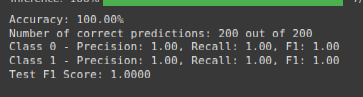

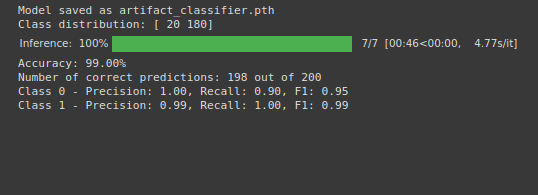

To my mind, that is great result.